In [60]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
import warnings
import glob
import string
import re


from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from collections import Counter

#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
from bs4 import BeautifulSoup

# New Section

In [61]:
all_files = glob.glob("data/*.csv")
data = pd.concat((pd.read_csv(f, encoding="utf-8-sig") for f in all_files))
data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z12pgdhovmrktzm3i23es5d5junftft3f,lekanaVEVO1,2014-07-22T15:27:50,i love this so much. AND also I Generate Free ...,1
1,z13yx345uxepetggz04ci5rjcxeohzlrtf4,Pyunghee,2014-07-27T01:57:16,http://www.billboard.com/articles/columns/pop-...,1
2,z12lsjvi3wa5x1vwh04cibeaqnzrevxajw00k,Erica Ross,2014-07-27T02:51:43,Hey guys! Please join me in my fight to help a...,1
3,z13jcjuovxbwfr0ge04cev2ipsjdfdurwck,Aviel Haimov,2014-08-01T12:27:48,http://psnboss.com/?ref=2tGgp3pV6L this is the...,1
4,z13qybua2yfydzxzj04cgfpqdt2syfx53ms0k,John Bello,2014-08-01T21:04:03,Hey everyone. Watch this trailer!!!!!!!! http...,1


In [62]:
def text_clear(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', 'HTTPLINK', text) # replace all LINKS to one word to represent all link as one
    soup = BeautifulSoup(text)
    return soup.get_text().replace("\ufeff", "") # some of the words contains UTF-8 BOM mark, so we remove tags and this mark too

data = data.drop(["COMMENT_ID", "AUTHOR", "DATE"], axis=1)
data['CONTENT'] = data['CONTENT'].apply(text_clear)
data.head()

,CONTENT,CLASS
0,i love this so much. AND also I Generate Free ...,1
1,HTTPLINK,1
2,Hey guys! Please join me in my fight to help a...,1
3,HTTPLINK,1
4,Hey everyone. Watch this trailer!!!!!!!! http...,1


In [63]:
nltk.download("punkt")
nltk.download('stopwords')

warnings.filterwarnings('ignore')

ham_words = ''
spam_words = ''

for val in data[data['CLASS'] == 1].CONTENT:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Creating a corpus of ham messages
for val in data[data['CLASS'] == 0].CONTENT:
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


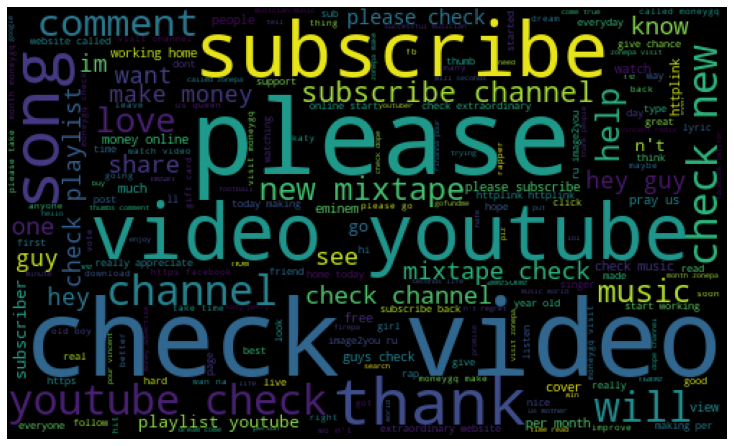

In [64]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

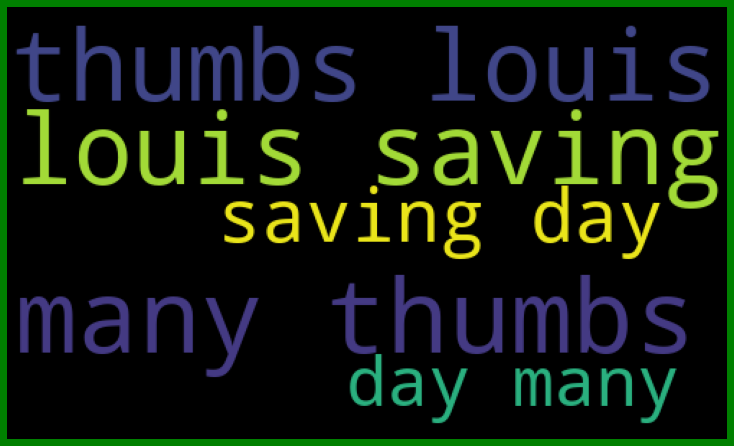

In [65]:
#Creating Ham wordcloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [66]:
#remove the punctuations and stopwords
def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

data['CONTENT'] = data['CONTENT'].apply(text_process)

CONTENT = pd.DataFrame(data['CONTENT'])
CLASS = pd.DataFrame(data['CLASS'])

total_counts = Counter()
for i in range(len(CONTENT)):
    for word in CONTENT.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  4049


In [67]:
# Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['check', 'video', 'song', 'like', 'please', 'subscribe', 'youtube', 'love', 'channel', 'im', 'music', 'new', 'guys', 'views', 'get', 'dont', 'hey', 'make', 'people', 'money', 'best', 'httplink', 'katy', 'good', 'comment', 'know', 'videos', 'would', 'see', 'thank', 'u', 'one', 'much', 'thanks', 'really', 'time', '2', 'old', 'go', 'world', 'us', 'eminem', 'could', 'help', 'perry', 'billion', 'everyone', 'visit', 'want', 'called', 'songs', 'thumbs', '3', 'give', 'shakira', 'share', 'mixtape', 'still', '1', 'free']


In [68]:
vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

# Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

# Convert all titles to vectors
word_vectors = np.zeros((len(CONTENT), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(CONTENT.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['CONTENT'])

#features = word_vectors
features = vectors

X_train, X_test, y_train, y_test = train_test_split(features, data['CLASS'], test_size=0.15, random_state=99) #


In [69]:

#initialize multiple classification models
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=99)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=99)

#create a dictionary of variables and models
clfs = {'Support Vector' : svc,'KNeighbors' : knc, 'Multinomial Naive Bayes': mnb, 'Decision Tree': dtc, 'Logistic Regression': lrc, 'Random Forest': rfc}

#fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    
    pred_scores_word_vectors.append((k, accuracy_score(y_test , pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred)))

pd.DataFrame(pred_scores_word_vectors, columns=["Classification model", "Accuracy", "Precision Score", "Recall Score", "F1 Score"])

,Classification model,Accuracy,Precision Score,Recall Score,F1 Score
0,Support Vector,0.928571,0.937931,0.918919,0.928328
1,KNeighbors,0.823129,0.828767,0.817568,0.823129
2,Multinomial Naive Bayes,0.908163,0.917241,0.898649,0.907850
3,Decision Tree,0.918367,0.918919,0.918919,0.918919
4,Logistic Regression,0.918367,0.962687,0.871622,0.914894
5,Random Forest,0.935374,0.964029,0.905405,0.933798


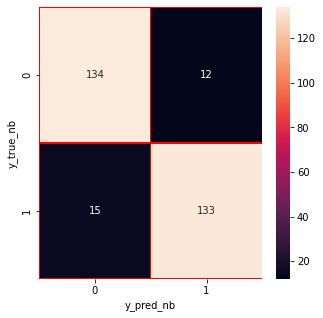

In [70]:

# Naive Bayes
y_pred_nb = mnb.predict(X_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_nb")
plt.ylabel("y_true_nb")
plt.show()


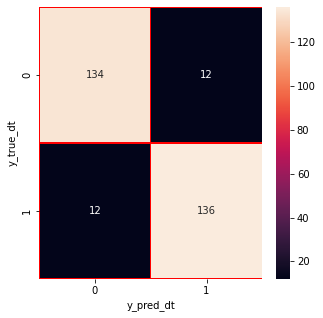

In [71]:
# DecisionTreeClassifier
y_pred_dt = dtc.predict(X_test)
y_true_dt = y_test
cm = confusion_matrix(y_true_dt, y_pred_dt)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_dt")
plt.ylabel("y_true_dt")
plt.show()

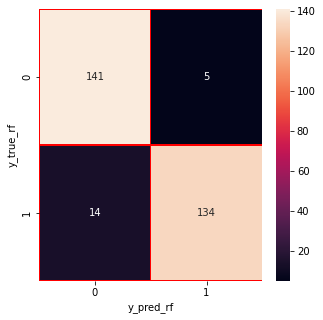

In [72]:
# RandomForestClassifier
y_pred_rf = rfc.predict(X_test)
y_true_rf = y_test
cm = confusion_matrix(y_true_nb, y_pred_rf)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_rf")
plt.ylabel("y_true_rf")
plt.show()